# Using the default resnet

## Imports

In [25]:
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
from torch import Tensor
from scipy import ndimage
from PIL import Image
import numpy as np
#from typing import Type, Any, Callable, Union, List, Optional, Tuple
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,Subset
from torchvision.models import resnet18

## Parameters

In [4]:
USE_GPU = True
CATALOG_PATH = '../Data/subset_gz1_desi_cross_cat.csv'
DATA_PATH = '../Data/Subset'

In [5]:
#Run processes on CPU or GPU
if USE_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cpu


## Importing data

In [6]:
catalog = pd.read_csv(CATALOG_PATH)
print(f"Loaded {catalog.shape[0]} galaxy images")

#Select features (clockwise and anti-clockwise probabilities)
Y = catalog[['P_CW','P_ACW']]
classes = [r'P_CW',r'P_ACW']

Loaded 1500 galaxy images


### Generate list of file locations from catalog

In [7]:
def get_file_paths(catalog_to_convert,folder_path ):
    brick_ids = catalog_to_convert['dr8_id'].str.split("_",expand=True)[0]
    dr8_ids = catalog_to_convert['dr8_id']
    file_locations = folder_path+'/'+brick_ids+'/'+dr8_ids+'.jpg'
    return file_locations

file_locations = get_file_paths(catalog,DATA_PATH)

### Image processing functions

In [8]:
COLOR = True
RAW_SIZE = 15
IMG_SIZE = 160

TARGET_SIZE = 5
TRANSLATE = 0.
ROTATE = False
FLIP = False
LABEL = 2
SHUFFLE = False


def img_proc(img, raw_size=RAW_SIZE, target_size=TARGET_SIZE, translate=TRANSLATE, rotate=ROTATE,
             random_generator=None):
    assert img.shape[-2] == img.shape[-1]
    assert translate >= 0
    
    if random_generator is None:
        random_generator = int.from_bytes(os.urandom(4), byteorder='little')
    rng = np.random.default_rng(random_generator)

    if not isinstance(target_size, (float, int)):
        target_size = rng.uniform(*target_size)
    if rotate:
        assert target_size * (1 + translate) * 2**0.5 < raw_size
        if isinstance(rotate, bool):
            rotate = rng.uniform(0., 360.)
        img = ndimage.rotate(img, rotate, axes=(-1, -2), reshape=False, order=1)
    else:
        assert target_size * (1 + translate) < raw_size
    s = img.shape[-1]
    translate = translate * target_size
    t_x = rng.uniform(-translate, translate) if translate > 0 else 0
    t_y = rng.uniform(-translate, translate) if translate > 0 else 0
    a = int(s * (raw_size - target_size + t_x) / (2 * raw_size))
    b = int(s * (raw_size - target_size + t_y) / (2 * raw_size))
    c = int(s * target_size / raw_size)
    return img[..., a:(a + c), b:(b + c)]


def read_img(path, color=COLOR, img_size=IMG_SIZE, atleast_3d=True, random_flip=FLIP,
             shuffle_channel=SHUFFLE, random_generator=None, **kwargs):
    if random_generator is None:
        random_generator = int.from_bytes(os.urandom(4), byteorder='little')
    rng = np.random.default_rng(random_generator)

    jpeg_file = (np.asarray(Image.open(path)) / 255).astype(np.float32)
    if color:
        img = np.moveaxis(jpeg_file, -1, 0)
        if shuffle_channel:
            if isinstance(shuffle_channel, bool):
                shuffle_channel = rng.permutation(img.shape[0])
            img = img[shuffle_channel]
    else:
        img = np.mean(jpeg_file, axis=-1)
    img = img_proc(img, random_generator=rng, **kwargs)
    rng.uniform(size=100) # just to jump the rng

    if img_size is not None:
        z = img_size / img.shape[-1]
        if img.ndim == 2:
            img = ndimage.zoom(img, (z, z), order=1)
            if atleast_3d:
                img = img[np.newaxis]
        elif img.ndim == 3:
            img = ndimage.zoom(img, (1, z, z), order=1)
        else:
            raise RuntimeError

    if random_flip:
        flip = int(rng.integers(0, 2, 1))
        flip = 2 * flip - 1
    else:
        flip = 1
    return np.ascontiguousarray(img[..., ::flip])

### Reading in images

In [9]:
#Takes 2 mins 20
X = torch.empty(0, 3, 160,160)
for i in range(len(file_locations)):
    X = torch.cat((X, torch.from_numpy(read_img(file_locations[i])).float()[np.newaxis]), 0)

In [10]:
print(f"Processed {X.shape[0]} images")

Processed 1500 images


## Setting up model

In [11]:
selected_model = resnet18(num_classes=2)

### Hyperparameters

In [12]:
learning_rate = 0.0001
weight_decay = 1

num_epochs = 120
batch_size = 60 #60

modfile = 'resnet18_modfile.pt'

### Training model function

In [13]:
def train(model, trainloader, optimiser, device):
    train_loss = 0.0
    model.train()

    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)
        optimiser.zero_grad()

        #Calculate train loss
        output = model(data)
        loss_criterion = nn.CrossEntropyLoss()
        labels = labels.to(device)        
        loss = loss_criterion(output, labels)
            
        train_loss += loss.item() * data.size(0)
        
        #Feed the loss back
        loss.backward()
        optimiser.step()

    train_loss /= len(trainloader.dataset)
    return train_loss

### Validating model function

In [14]:
#function to test the model on data
def validate(model, testloader, device):
    prediction=[]
    target=[]
    correct = 0
    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(testloader):
            data, labels = data.to(device), labels.to(device)

            p_y = model(data)
            #Calculate test loss
            loss_criterion = nn.CrossEntropyLoss()
            labels = labels.to(device)
            loss = loss_criterion(p_y, labels)
                
            test_loss += loss.item() * data.size(0)
            
            #values for metrics
            #preds = p_y.argmax(dim=1, keepdim=True)
            #correct += preds.eq(labels.view_as(preds)).sum().item()
            #prediction+=preds.squeeze(1).tolist()
            #target+=labels.tolist()
        test_loss /= len(testloader.dataset)
        accuracy = correct / len(testloader.dataset)

        #calculate ROC score metric
            # roc_auc = roc_auc_score(target, prediction)
            # recall = recall_score(target, prediction)
            # f1 = f1_score(target, prediction)
            # precision = precision_score(target, prediction)
    return test_loss, accuracy#, roc_auc, prediction, target, recall, f1, precision

### Split data into train and test

In [15]:
def data_split(frac_val, data):
    dataset_size = len(data)
    nval = int(frac_val*dataset_size)

    indices = list(range(dataset_size))
    train_indices, val_indices = indices[nval:], indices[:nval]

    train_sampler = Subset(data, train_indices)
    valid_sampler = Subset(data, val_indices)

    train_loader = torch.utils.data.DataLoader(train_sampler, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(valid_sampler, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

## Running model

In [20]:
#function to run the entire model train/test loop
TEST_USE = False
early_stopping = True
QUIET = False
def run_func(X,Y,model):
    X_tensor = X
    Y_tensor = torch.from_numpy(Y.values).float()

    dataset = TensorDataset(X_tensor, Y_tensor)
    train_loader,val_loader = data_split(0.7,dataset)

    if TEST_USE: #Doesn't currently work
        val_loader, test_loader = data_split(0.5,val_loader)

    #optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)#0.005, #0.01
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.15)

    #array to store metrics
    result_arr = np.zeros((num_epochs,4))

    _bestloss = 1.
    #NN learning
    for epoch in range(num_epochs):
    
        train_loss = train(model, train_loader, optimizer, device)
        val_loss, accuracy= validate(model, val_loader, device)
        
        scheduler.step(val_loss)

        if early_stopping and val_loss<_bestloss:
            _bestloss = val_loss
            torch.save(model.state_dict(), modfile)
            best_epoch = epoch
            #cm = confusion_matrix(target, prediction,normalize = 'true')

        #set output row
        results = [epoch, train_loss, val_loss, accuracy]
        result_arr[epoch] = results

        #print epoch results
        if not QUIET:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:4f}, Validation Loss: {val_loss:4f}, Validation Accuracy: {accuracy:4f}')
            #print('Current learning rate is: {}'.format(optimizer.param_groups[0]['lr']))
    
    test_arr=[]
    if TEST_USE:
        #Test data run
        bestmodel=selected_model().to(device)
        bestmodel.load_state_dict(torch.load('modfile.pt'))
        test_loss, test_accuracy, test_auc, prediction2,target2,  recall2, f12, precision2 = validate(bestmodel, test_loader, device)
        test_arr=[test_loss, test_accuracy, test_auc, prediction2,target2,  recall2, f12, precision2]

    if not early_stopping:
        torch.save(model.state_dict(), modfile)
        best_epoch = -1
        #cm = confusion_matrix(target, prediction,normalize = 'true')

    return result_arr, test_arr, best_epoch

## Actually run model

In [21]:
result_arr1, test_arr1, best_epoch = run_func(X,Y,selected_model)

/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0, Validation Loss: 0.997662, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 1, Validation Loss: 1.106931, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 2, Validation Loss: 0.765707, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 3, Validation Loss: 0.675494, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 4, Validation Loss: 0.739463, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 5, Validation Loss: 0.748909, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 6, Validation Loss: 1.004227, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 7, Validation Loss: 0.732432, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 8, Validation Loss: 0.948126, Validation Accuracy: 0.000000
Current learning rate is: 0.0001
Epoch: 9, Validation Loss: 0.894956, Validation Accuracy: 0.000000
Current learning rate is: 0.0001


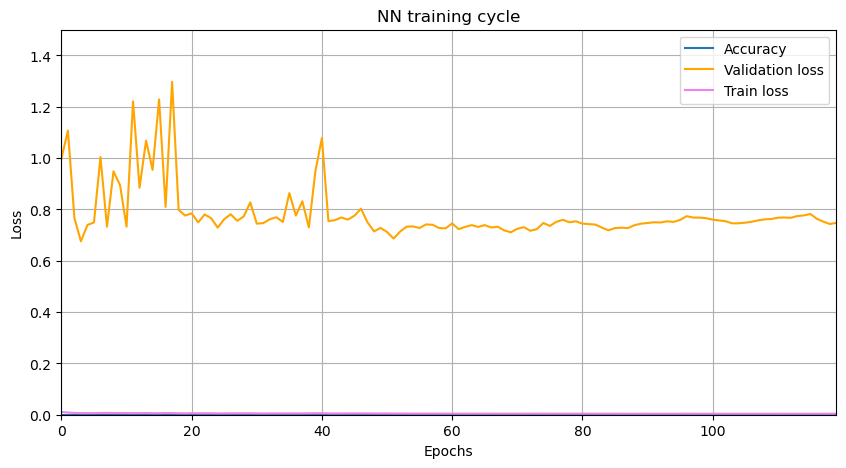

In [32]:
#plot the training cycle
plt.figure(figsize=(10,5))
plt.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', label='Accuracy')
plt.plot(result_arr1[:,0],result_arr1[:,2],linestyle='-', c='orange',label='Validation loss')
plt.plot(result_arr1[:,0],result_arr1[:,1],linestyle='-', c='violet',label='Train loss')
plt.ylim(0,1.5)
plt.xlim(0,num_epochs-1)
plt.title('NN training cycle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()